In [1]:
import numpy as np
from tqdm import trange

import pickle

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})

SAVE = False

# Model





In [218]:
class MagnetAssemblySim1D:

    def __init__(
        self,
        E_M=0.0,
        E_D=1.5,
        E_Tr=2.5,
        E_T=100.0,
        E_P=4.5,
        activation_energy=0.1,
        system_size=400,
        n_orientations=8,
    ):

        self.n_species = 6  # species 0 is dummy (empty space, never used)

        self.size = system_size
        self.n_orientations = n_orientations

        self.species = np.arange(self.n_species)

        self.complex_energy = {
            1: E_M,
            2: E_D,
            3: E_Tr,
            4: E_T,
            5: E_P,
        }
        self.activation_energy = activation_energy

        # Initialize the state of the system
        self.state = np.ones(self.size, dtype=int)
        self.orientations = np.random.choice(
            np.arange(self.n_orientations), size=self.size
        )

        # Initialize the neighbor lists (tracks bindings)
        self.neighbors = dict([(i, []) for i in range(self.size)])

        self.bind_reactions = {
            (1, 1): 2,
            (1, 2): 3,
            (1, 3): 4,
            (2, 3): 5,
            (3, 2): 5,
        }

        self.unbind_reactions = {
            2: (1, 1),
            3: (1, 2),
            4: (1, 1, 1, 1),
            5: (2, 3),
        }

    def energy(self):
        """
        Calculate the total energy of the system.
        """
        return -np.sum(self.complex_energy[self.state])

    def species_counts(self):
        """
        Return counts of each species.
        """
        return np.asarray([np.sum(self.state == i) for i in self.species]) // np.where(
            self.species > 0, self.species, 1
        )

    def bind(self, i, j, reaction):
        """
        Carry out BINDING reaction - update states, orientations and neighbor lists.
        """

        new_species = self.bind_reactions[reaction]
        state_change = np.sort([i, j] + self.neighbors[i] + self.neighbors[j])

        self.state[state_change] = new_species

        # update neighbors
        old_n_i = self.neighbors[i].copy()
        old_n_j = self.neighbors[j].copy()

        self.neighbors[i] += [j] + old_n_j
        self.neighbors[j] += [i] + old_n_i

        for k in old_n_j:
            self.neighbors[k] += [i] + old_n_i
        for k in old_n_i:
            self.neighbors[k] += [j] + old_n_j

    def unbind(self, i, reaction):
        """
        Carry out UNBINDING reaction - update states, orientations and neighbor lists.
        """

        state_change = [i] + self.neighbors[i]

        if reaction == 2 or reaction == 4:  # break up dimer or tetramer

            new_species = np.asarray(self.unbind_reactions[reaction])
            self.state[state_change] = new_species
            self.orientations[state_change] = np.random.choice(
                np.arange(self.n_orientations), size=len(state_change)
            )
            # update neighbors
            for i in state_change:
                self.neighbors[i] = []

        if reaction == 3:  # break up trimer

            # choose which bond to break (left or right)
            bond_to_break = np.random.choice([0, -1])
            new_species = np.asarray([2, 2, 2])
            new_species[bond_to_break] = 1

            state_change = np.sort(state_change)
            self.state[state_change] = new_species

            # update neighbors
            self.neighbors[state_change[0]] = (
                [] if bond_to_break == 0 else [state_change[1]]
            )
            self.neighbors[state_change[1]] = [
                state_change[0] if bond_to_break == -1 else state_change[2]
            ]
            self.neighbors[state_change[2]] = (
                [] if bond_to_break == -1 else [state_change[1]]
            )

            self.orientations[state_change[bond_to_break]] = np.random.choice(
                np.arange(self.n_orientations)
            )

        if reaction == 5:  # brek up pentamer

            # choose if break up into (2, 3) or (3, 2)
            outcome = np.random.choice([0, 1])
            new_species = np.array([(2, 2, 3, 3, 3), (3, 3, 3, 2, 2)][outcome])

            state_change = np.sort(state_change)
            self.state[state_change] = new_species

            # update neighbors
            self.neighbors[state_change[0]] = (
                [state_change[1]]
                if outcome == 0
                else [state_change[1], state_change[2]]
            )
            self.neighbors[state_change[1]] = (
                [state_change[0]]
                if outcome == 0
                else [state_change[0], state_change[2]]
            )
            self.neighbors[state_change[2]] = (
                [state_change[3], state_change[4]]
                if outcome == 0
                else [state_change[0], state_change[1]]
            )
            self.neighbors[state_change[3]] = (
                [state_change[2], state_change[4]]
                if outcome == 0
                else [state_change[4]]
            )
            self.neighbors[state_change[4]] = (
                [state_change[2], state_change[3]]
                if outcome == 0
                else [state_change[3]]
            )

    def delta_energy(self, reaction):

        if reaction in self.unbind_reactions:
            reactant_energy = self.complex_energy[reaction]
            product_energy = np.sum(
                [self.complex_energy[c] for c in self.unbind_reactions[reaction]]
            )

        elif reaction in self.bind_reactions:
            reactant_energy = np.sum([self.complex_energy[c] for c in reaction])
            product_energy = self.complex_energy[self.bind_reactions[reaction]]
        else:
            reactant_energy = product_energy = 0

        return reactant_energy - product_energy

    def simulation_step(self, temperature):
        """
        Carry out one step in the simulation.
        """

        # choose random site
        i = np.random.randint(self.size)

        if self.state[i] == 1:  # monomer: try to rotate or bind

            # try to change orientation
            if np.random.uniform() < np.exp(-self.activation_energy / temperature):
                self.orientations[i] = np.random.choice(np.arange(self.n_orientations))

            # if high T spend all time rotating, so no binding at all
            else:  # try to bind

                # choose neighbor to try binding with
                j = i + np.random.choice([-1, 1])

                if j < 0 or j >= self.size:
                    # neighbor out of system boundaries
                    return

                if self.state[j] == 0:
                    # no binding with empty space
                    return

                if self.orientations[i] != self.orientations[j]:
                    # different orientations
                    return

                # select appropriate reaction
                reaction = (self.state[i], self.state[j])

                if reaction in self.bind_reactions:  # check if reaction is allowed

                    delta_e = self.delta_energy(reaction)
                    p = np.exp(
                        -max(self.activation_energy, delta_e + self.activation_energy)
                        / temperature
                    )

                    if np.random.uniform() < p:
                        self.bind(i, j, reaction)  # BIND MONOMER

        else:  # not a monomer - try to break or form a pentamer

            reaction = int(self.state[i])

            # try to break
            if reaction in self.unbind_reactions:

                delta_e = self.delta_energy(reaction)
                p = np.exp(
                    -max(self.activation_energy, delta_e + self.activation_energy)
                    / temperature
                )

                if np.random.uniform() < p:
                    self.unbind(i, reaction)  # UNBIND COMPLEX

                # didn't break - try to to create pentamer
                else:

                    if self.state[i] == 2 or self.state[i] == 3:

                        # choose neighbor to bind with
                        j = i + np.random.choice([-1, 1])

                        if j < 0 or j >= self.size:
                            # neighbor out of system boundaries
                            return

                        if self.state[j] == 0:
                            # no binding with empty space
                            return

                        if self.orientations[i] != self.orientations[j]:
                            # different orientations
                            return

                        if j in self.neighbors[i]:
                            # selected a piece in the same complex - already bound
                            return

                        if self.state[j] == 2 or self.state[j] == 3:
                            # other piece is a dimer or trimer - try to bind

                            # check if reaction is allowed
                            reaction = (self.state[i], self.state[j])

                            if reaction in self.bind_reactions:

                                delta_e = self.delta_energy(reaction)
                                p = np.exp(
                                    -max(
                                        self.activation_energy,
                                        delta_e + self.activation_energy,
                                    )
                                    / temperature
                                )

                                if np.random.uniform() < p:
                                    self.bind(i, j, reaction)  # BIND PENTAMER

    def simulate(self, steps, temperature):
        """
        Run the simulation for a given number of steps.
        """

        species_counts = np.zeros((steps, self.n_species))

        for step in range(steps):
            self.simulation_step(temperature)
            species_counts[step] = self.species_counts()

        return species_counts

## Single simulation

In [179]:
# Set simulation parameters
n_particles = 400
n_steps = int(2.5e5)
temperature = 0.3  # Adjust this to change the equilibrium state

# Run the simulation
sim = MagnetAssemblySim1D()
species_counts = sim.simulate(n_steps, temperature)
yields_single = species_counts * np.arange(sim.n_species) / sim.size

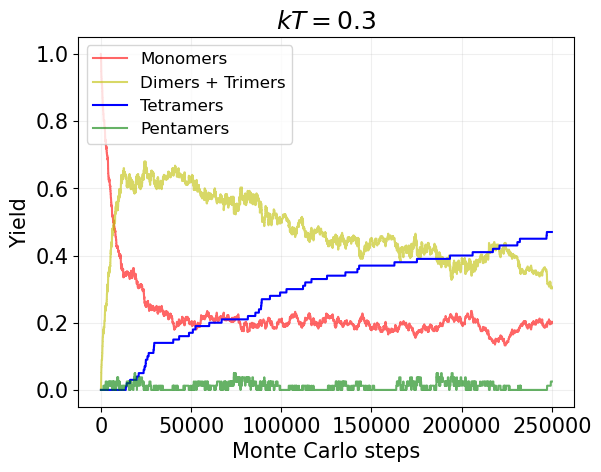

In [203]:
def plot_sim(yields, kT, save_pkl=False):

    plt.plot(yields[:, 1], "r", label="Monomers", alpha=0.6)
    plt.plot(yields[:, 2] + yields[:, 3], "y", label="Dimers + Trimers", alpha=0.6)
    plt.plot(yields[:, 4], "b", label="Tetramers")
    plt.plot(yields[:, 5], "g", label="Pentamers", alpha=0.6)

    plt.legend(fontsize=12, loc="upper left")
    plt.xlabel("Monte Carlo steps")
    plt.ylabel("Yield")
    plt.grid(alpha=0.2)

    plt.title("$kT = $" + f"${kT:.3}$")

    if save_pkl:
        with open("figs/fig_sim.pkl", "wb") as f:
            pickle.dump(plt.gcf(), f)

    # return the created figure
    return plt.gcf(), plt.gca()


fig, ax = plot_sim(yields_single, kT=temperature, save_pkl=SAVE)

if SAVE:
    fig.savefig("figs/PDF/fig_sim.pdf", bbox_inches="tight")

# QUENCHING: Yield vs Temperature

In [5]:
Ts = np.logspace(-1.5, 1.0, 21)

n_particles = 400
n_steps = int(2.5e5)
n_reps = 20

sim = MagnetAssemblySim1D(system_size=n_particles)  # dummy
quench_yields_T = np.zeros((n_reps, len(Ts), sim.n_species))

for rep in trange(n_reps):

    for i, T in enumerate(Ts):

        sim = MagnetAssemblySim1D(system_size=n_particles)
        species_counts = sim.simulate(n_steps, T)

        quench_yields_T[rep, i] = (
            np.mean(species_counts[-5000:], axis=0)
            * np.arange(sim.n_species)
            / n_particles
        )

if SAVE:
    with open("data/quench_yields_T.pkl", "wb") as f:
        pickle.dump(quench_yields_T, f)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [43:16<00:00, 129.84s/it]


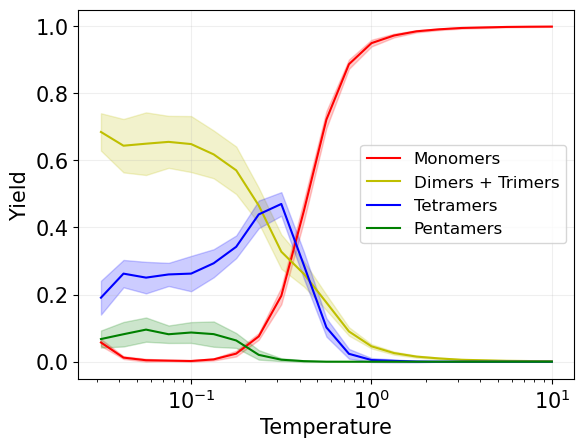

In [6]:
def plot_quench_yields(quench_yields, Ts, save_pkl=False):

    yields = np.mean(quench_yields, axis=0)
    stds = np.std(quench_yields, axis=0)

    plt.plot(Ts, yields[:, 1], "r", label="Monomers")
    plt.plot(Ts, yields[:, 2] + yields[:, 3], "y", label="Dimers + Trimers")
    plt.plot(Ts, yields[:, 4], "b", label="Tetramers")
    plt.plot(Ts, yields[:, 5], "g", label="Pentamers")

    plt.fill_between(
        Ts, yields[:, 1] - stds[:, 1], yields[:, 1] + stds[:, 1], color="r", alpha=0.2
    )
    plt.fill_between(
        Ts,
        yields[:, 2] + yields[:, 3] - stds[:, 2] - stds[:, 3],
        yields[:, 2] + yields[:, 3] + stds[:, 2] + stds[:, 3],
        color="y",
        alpha=0.2,
    )
    plt.fill_between(
        Ts, yields[:, 4] - stds[:, 4], yields[:, 4] + stds[:, 4], color="b", alpha=0.2
    )
    plt.fill_between(
        Ts, yields[:, 5] - stds[:, 5], yields[:, 5] + stds[:, 5], color="g", alpha=0.2
    )

    plt.xscale("log")

    plt.legend(fontsize=12, loc="center right")

    plt.xlabel("Temperature")
    plt.ylabel("Yield")
    plt.grid(alpha=0.2)

    if save_pkl:
        with open("figs/fig_quench_yields_T.pkl", "wb") as f:
            pickle.dump(plt.gcf(), f)

    # return the created figure
    return plt.gcf(), plt.gca()


fig, ax = plot_quench_yields(quench_yields_T, Ts, save_pkl=SAVE)

# MELTING: Yield vs Temperature

In [17]:
Ts = np.logspace(-0.3, 1.7, 21)

T_quench = 0.15

n_particles = 400
n_steps = int(1.5e5)
n_reps = 20


melt_yields_T = np.zeros((n_reps, len(Ts), sim.n_species))

for rep in trange(n_reps):

    for i, T in enumerate(Ts):

        sim = MagnetAssemblySim1D(system_size=n_particles)
        init_yields = sim.simulate(n_steps, T_quench)

        init_yields = (
            np.mean(init_yields[-5000:], axis=0)
            * np.arange(sim.n_species)
            / n_particles
        )

        final_yields = sim.simulate(n_steps, T)
        final_yields = (
            np.mean(final_yields[-5000:], axis=0)
            * np.arange(sim.n_species)
            / n_particles
        )

        melt_yields_T[rep, i] = final_yields / (init_yields + 1e-8)

if SAVE:
    with open("data/melt_yields_T.pkl", "wb") as f:
        pickle.dump(melt_yields_T, f)

100%|██████████| 20/20 [51:35<00:00, 154.77s/it]


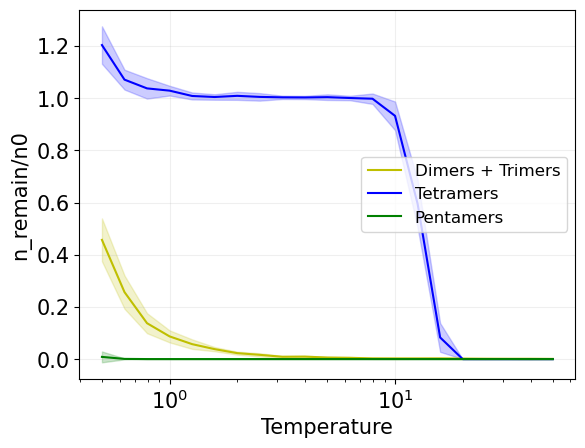

In [18]:
def plot_melt_yields(melt_yields, Ts, save_pkl=False):

    yields = np.mean(melt_yields, axis=0)
    stds = np.std(melt_yields, axis=0)

    plt.plot(Ts, yields[:, 2] + yields[:, 3], "y", label="Dimers + Trimers")
    plt.plot(Ts, yields[:, 4], "b", label="Tetramers")
    plt.plot(Ts, yields[:, 5], "g", label="Pentamers")

    plt.fill_between(
        Ts,
        yields[:, 2] + yields[:, 3] - stds[:, 2] - stds[:, 3],
        yields[:, 2] + yields[:, 3] + stds[:, 2] + stds[:, 3],
        color="y",
        alpha=0.2,
    )
    plt.fill_between(
        Ts, yields[:, 4] - stds[:, 4], yields[:, 4] + stds[:, 4], color="b", alpha=0.2
    )
    plt.fill_between(
        Ts, yields[:, 5] - stds[:, 5], yields[:, 5] + stds[:, 5], color="g", alpha=0.2
    )

    plt.xscale("log")

    plt.legend(fontsize=12, loc="center right")

    plt.xlabel("Temperature")
    plt.ylabel("n_remain/n0")
    plt.grid(alpha=0.2)

    if save_pkl:
        with open("figs/fig_melt_yields_T.pkl", "wb") as f:
            pickle.dump(plt.gcf(), f)

    # return the created figure
    return plt.gcf(), plt.gca()


fig, ax = plot_melt_yields(melt_yields_T, Ts, save_pkl=SAVE)

# CYCLING

## Single simulation

In [195]:
def simulate_cycling(sim, Th, Tl, Th_steps, Tl_steps, n_steps):

    steps_per_cycle = Th_steps + Tl_steps
    n_cycles = n_steps // steps_per_cycle

    n_steps = n_cycles * steps_per_cycle

    yields_cycle = np.zeros((n_steps, 6))

    for cycle in range(n_cycles):

        consumed_steps = cycle * steps_per_cycle

        sim.temperature = Tl
        s = sim.simulate(Tl_steps, Tl)
        yields_cycle[consumed_steps : consumed_steps + Tl_steps] = (
            s * np.arange(sim.n_species) / sim.size
        )

        consumed_steps += Tl_steps

        sim.temperature = Th
        s = sim.simulate(Th_steps, Th)
        yields_cycle[consumed_steps : consumed_steps + Th_steps] = (
            s * np.arange(sim.n_species) / sim.size
        )

    return yields_cycle

In [196]:
n_steps = int(2.5e5)

Th = 0.8
Tl = 0.2
Th_steps = int(2e3)
Tl_steps = int(2e4)

sim_cycle = MagnetAssemblySim1D()

yields_cycle_avg = simulate_cycling(sim_cycle, Th, Tl, Th_steps, Tl_steps, n_steps)

100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


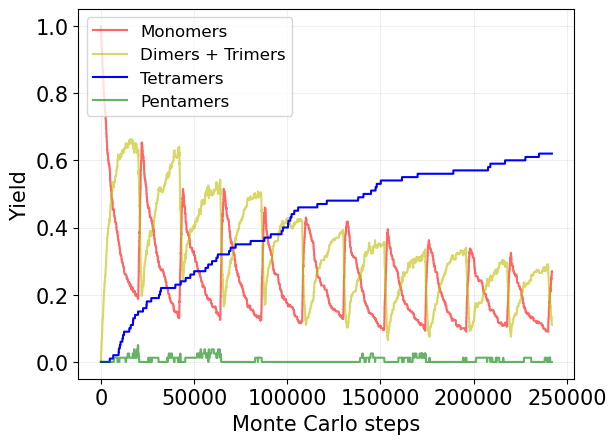

In [201]:
def plot_sim_cycling(yields, save_pkl=False):

    plt.plot(yields[:, 1], "r", label="Monomers", alpha=0.6)
    plt.plot(yields[:, 2] + yields[:, 3], "y", label="Dimers + Trimers", alpha=0.6)
    plt.plot(yields[:, 4], "b", label="Tetramers")
    plt.plot(yields[:, 5], "g", label="Pentamers", alpha=0.6)

    plt.legend(fontsize=12, loc="upper left")
    plt.xlabel("Monte Carlo steps")
    plt.ylabel("Yield")
    plt.grid(alpha=0.2)

    if save_pkl:
        with open("figs/fig_sim_cycling.pkl", "wb") as f:
            pickle.dump(plt.gcf(), f)

    # return the created figure
    return plt.gcf(), plt.gca()


fig, ax = plot_sim_cycling(yields_cycle_avg, save_pkl=SAVE)

if SAVE:
    fig.savefig("figs/PDF/fig_sim_cycling.pdf", bbox_inches="tight")

## Average tetramer yield

In [205]:
# average over multiple runs
n_reps = 20

n_steps = int(2.5e5)

Th = 0.8
Tl = 0.2
Th_steps = int(2e3)
Tl_steps = int(2e4)

sim_cycle = MagnetAssemblySim1D()

yields_cycle_reps = np.zeros((n_reps, n_steps, sim_cycle.n_species))

for rep in trange(n_reps):
    sim_cycle = MagnetAssemblySim1D()

    if 0 == rep:
        buff = simulate_cycling(sim_cycle, Th, Tl, Th_steps, Tl_steps, n_steps)
        n_steps = buff.shape[0]
        yields_cycle_reps = np.zeros((n_reps, n_steps, sim_cycle.n_species))
        yields_cycle_reps[rep] = buff
    else:
        yields_cycle_reps[rep] = simulate_cycling(
            sim_cycle, Th, Tl, Th_steps, Tl_steps, n_steps
        )


if SAVE:
    with open("data/yields_cycle_reps.pkl", "wb") as f:
        pickle.dump(yields_cycle_reps, f)

100%|██████████| 20/20 [03:32<00:00, 10.63s/it]


In [209]:
# average over multiple runs
kT = 0.3

sim_single = MagnetAssemblySim1D()

yields_sim_reps = np.zeros((n_reps, n_steps, sim_single.n_species))

for rep in trange(n_reps):
    sim_single = MagnetAssemblySim1D()
    counts = sim_single.simulate(n_steps, kT)
    yields_sim_reps[rep] = counts * np.arange(sim_single.n_species) / sim_cycle.size


if SAVE:
    with open("data/yields_sim_reps.pkl", "wb") as f:
        pickle.dump(yields_sim_reps, f)

100%|██████████| 20/20 [03:29<00:00, 10.48s/it]


In [212]:
def plot_cycling_single_tetram_cmp(yields_cycle, yields_sim, save_pkl=False):

    avg_cycle = np.mean(yields_cycle, axis=0)
    std_cycle = np.std(yields_cycle, axis=0)

    avg_sim = np.mean(yields_sim, axis=0)
    std_sim = np.std(yields_sim, axis=0)

    plt.plot(avg_cycle[:, 4], "r", label="Cycling kT")
    plt.fill_between(
        np.arange(n_steps),
        avg_cycle[:, 4] - std_cycle[:, 4],
        avg_cycle[:, 4] + std_cycle[:, 4],
        color="r",
        alpha=0.2,
    )

    plt.plot(avg_sim[:, 4], "b", label="Fixed Optimal kT")
    plt.fill_between(
        np.arange(n_steps),
        avg_sim[:, 4] - std_sim[:, 4],
        avg_sim[:, 4] + std_sim[:, 4],
        color="b",
        alpha=0.2,
    )

    plt.legend(fontsize=12, loc="upper left")
    plt.xlabel("Monte Carlo steps")
    plt.ylabel("Tetramers yield")
    plt.grid(alpha=0.2)

    if save_pkl:
        with open("figs/fig_cycling_single_tetram_cmp.pkl", "wb") as f:
            pickle.dump(plt.gcf(), f)

    # return the created figure
    return plt.gcf(), plt.gca()

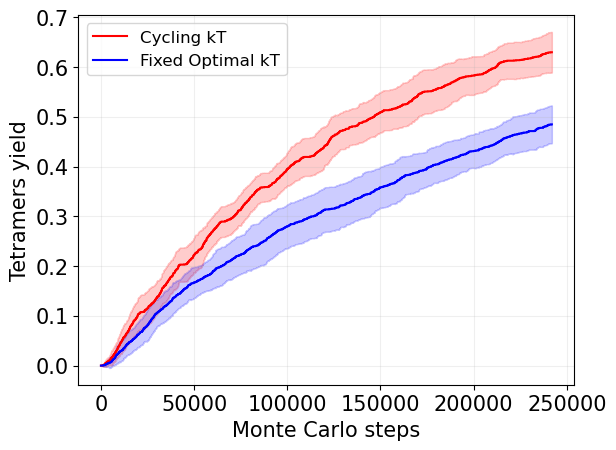

In [216]:
fig, ax = plot_cycling_single_tetram_cmp(
    yields_cycle_reps,
    yields_sim_reps,
    save_pkl=SAVE,
)

if SAVE:
    fig.savefig("figs/PDF/fig_cycling_single_tetram_cmp.pdf", bbox_inches="tight")